# Evaluation Farley|
This notebook is for inspecting the data and produce the desired results. It will use dataframes to do so.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import networkx as nx
import sys, os, csv, re, matplotlib
import numpy as np
from scipy import stats
os.chdir("..")

import src.parse as parse
from src.plot import plot_all, automatic_plotting

In [32]:
dfs = {}
columns = ["ID",'instance','method','terminated','n',"K",'total time','sol_val']
finished_columns = ['final bound',"elementary","cyc2"]
data = pd.DataFrame(columns=columns + finished_columns)
pattern = r"(E-n(\d+)-k(\d+))-(\w+)\.log"
for i, log in enumerate((log for log in os.listdir("output_farley"))):
    ID = log.strip(".log")
    instance, n, K, method = re.search(pattern, log).groups()
    log = f"output_farley/{log}"
    finished = parse.log_finished(log)
    sol_val = parse.parse_sol_val(instance)
    if finished:
        elementary, cyc2 = parse.parse_footer(log)
    
    df = parse.parse_output(log)
#     df["total time"] = df["total time"].cumsum()
    df = df[(df.method == method) | (df.method == "Farley")]
    dfs[f'{instance}-{method}'] = df
    if finished:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val, df['upper_bound'].iloc[-1], elementary, cyc2]],columns=columns+finished_columns)))
    else:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val]],columns=columns)))
data = data.set_index("ID")
data['n'] = data['n'].astype(int)
data['total time'] = data['total time'].astype(float)
data['n/K'] = data['n'].astype(float) / data['K'].astype(float)
data['lb/I'] = data['final bound'].astype(float) / data['sol_val'].astype(float)

21
38
32555.302631578947
23874.27105263158


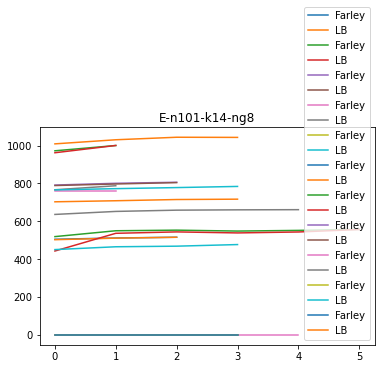

In [42]:
failed, better, total, tt, ttt = 0, 0, 0, 0, 0
for key,df in dfs.items():
    if not key.endswith("ng8"):
        continue
#     df = dfs["E-n33-k4-ng8"]
    df = df.iloc[:-2]
    dff = df[df.method == "Farley"].reset_index()
    dflb = df[df.method == "ng8"].reset_index()
    
    tt += (dff['total time'].cumsum()).iloc[-1]
    dff_fil = dff[dff['lower_bound'] == 0]
    if dff_fil.shape[0] > 0:
        ttt += (dff_fil['total time'].cumsum()).iloc[-1]
    
    failed += dff[dff['lower_bound'] == 0].shape[0]
    total += dff.shape[0]
    
    plt.plot(dff['lower_bound'],label="Farley")
    plt.plot(dflb['lower_bound'],label="LB")
    plt.title(key)
    plt.legend(loc="lower right")
#     plt.show()
print(failed)
print(total)
print(tt/total)
print(ttt/total)